# Teaching a Computer to Diagnose Cancer

This notebook is intended to accompany my presentation on "Teaching a Computer to Diagnose Cancer: An Introduction to Machine Learning."

## Load Python Dependencies

Python has a number of excellent libraries available for scientific computing. This notebook uses several, including:

- [Pandas: Data Analysis Library](http://pandas.pydata.org/)
- [Numpy: Linear Algebra Library](http://www.numpy.org/)
- [SciKit Learn: Machine Learning Library](http://scikit-learn.org/stable/)
- [MatPlotLib: 2D Plotting Library](http://matplotlib.org/)
- [Seaborn: Data Visualization Library](https://stanford.edu/~mwaskom/software/seaborn/)

In [1]:
import pandas as pd
import numpy as np
import sklearn.cross_validation
import sklearn.neighbors
import sklearn.metrics
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# enable matplotlib mode
%matplotlib inline

# configure plot readability
sns.set_style("white")
sns.set_context("talk")

## Load Dataset

We will use the [Wisconsin Breast Cancer Diagnostic Data Set](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29) (WDBC) to classify breast cancer cells as malignant or benign. This dataset has features computed from digital images of a fine needle aspirate (FNA) of breast mass. Each feature describes characteristics of the cell nuclei in a particular image. Since column headers are not included in the raw data, we manually encode the feature names.

- Number of Instances: 569
- Number of Attributes: 32 (ID, diagnosis, 30 real-valued input features)
- Class Distribution: 357 benign, 212 malignant

To simplify our analysis, we will focus on only two features: largest radius and worst texture.

In [2]:
columns_to_features = { 1: "Diagnosis",
                       22: "Radius",
                       23: "Texture"}

features_to_keep = columns_to_features.values()

wdbc = pd.read_csv("wdbc.data", header = None) \
         .rename(columns = columns_to_features) \
         .filter(features_to_keep, axis = 1) \
         .replace("M", "Malignant") \
         .replace("B", "Benign")

## Data Exploration

It's important to gain some insight and intuition about our data. This will help us choose the right statistical model to use.

We'll start by looking at 5 randomly selected observations from the dataset.

Notice that:
- The diagnosis is categorical and represented with a string label.
- The input features are real-valued.

In [3]:
wdbc.sample(5)

,Diagnosis,Radius,Texture
551,Benign,12.02,28.26
449,Malignant,25.68,32.07
243,Benign,15.01,26.34
497,Benign,14.06,24.34
468,Malignant,21.57,28.87


Next, let's compare the number of malignant and benign observations by plotting the class distribution.

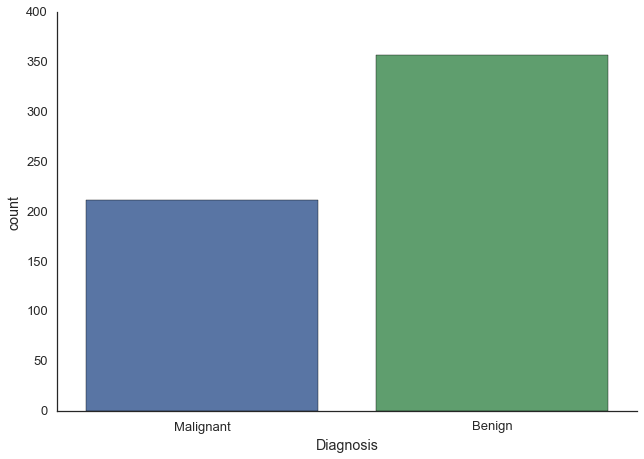

In [4]:
sns.countplot(x = "Diagnosis", data = wdbc)
sns.despine()

Let's plot the radius and texture for each observation.

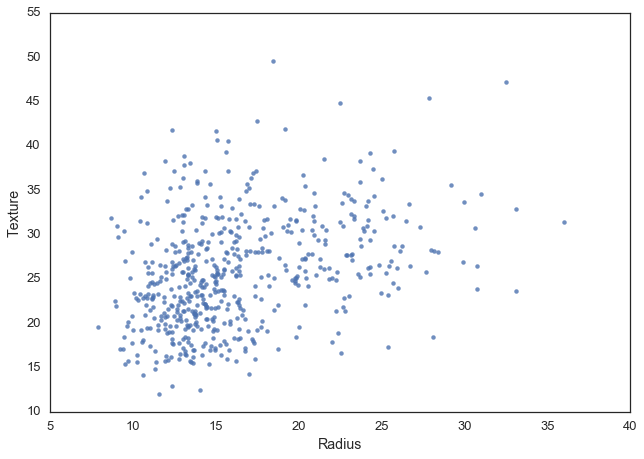

In [5]:
sns.regplot(wdbc["Radius"], wdbc["Texture"], fit_reg = False)

That's an interesting plot, but does it reveal anything? Let's take a closer look by generating the same plot, but color-coding it by diagnosis.

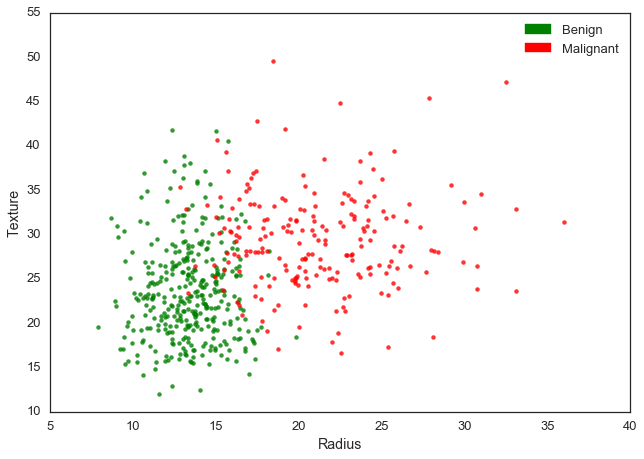

In [6]:
wdbc_benign = wdbc[wdbc["Diagnosis"] == "Benign"]
wdbc_malignant = wdbc[wdbc["Diagnosis"] == "Malignant"]

sns.regplot(wdbc_benign["Radius"], wdbc_benign["Texture"], color = "green", fit_reg = False)
sns.regplot(wdbc_malignant["Radius"], wdbc_malignant["Texture"], color = "red", fit_reg = False)

green_patch = mpatches.Patch(color = "green", label = "Benign")
red_patch = mpatches.Patch(color = "red", label = "Malignant")
plt.legend(handles=[green_patch, red_patch])

This plot shows that the radius of malignant cells tends to be much larger than the radius of benign cells. As a result, the data appears to "separate" when plotted--the benign cells are clustered together on the left side of the plot, while the malignant cells are clustered together on the right side. You can use this information to intuitively classify new cells.

For example, let's consider classifying the following (radius, texture) pairs:

- (10, 20): This point is close to benign (green) cells. Therefore, it's likely that this cell is also benign.
- (25, 30): This point is close to malignant (red) cells. Therefore, it's likely that this cell is also malignant.
- (15, 25): This point is close to both benign (green) and malignant (red) cells. However, there are more benign (green) cells near this point than malignant (red) cells. Therefore, our best guess is that this cell is benign.

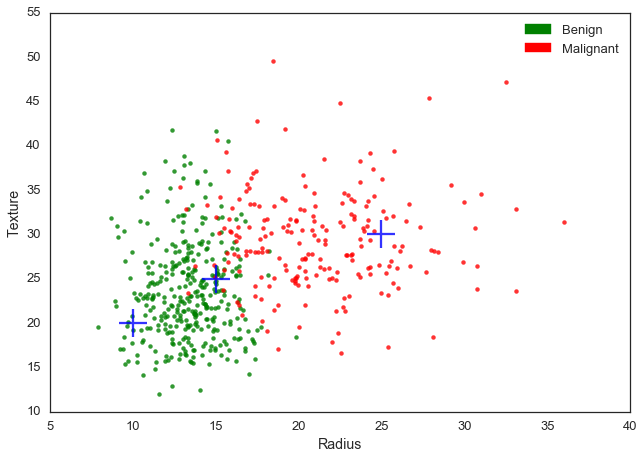

In [7]:
sns.regplot(wdbc_benign["Radius"], wdbc_benign["Texture"], color = "green", fit_reg = False)
sns.regplot(wdbc_malignant["Radius"], wdbc_malignant["Texture"], color = "red", fit_reg = False)

radii = np.array([10, 25, 15])
textures = np.array([20, 30, 25])
sns.regplot(radii, textures, color = "blue", fit_reg = False,
            marker = "+", scatter_kws = {"s": 800})

green_patch = mpatches.Patch(color = "green", label = "Benign")
red_patch = mpatches.Patch(color = "red", label = "Malignant")
plt.legend(handles=[green_patch, red_patch])

# k-Nearest Neighbors Algorithm

To classify the cells above, you intuitively applied a classification algorithm called k-nearest neighbors (kNN). Let's learn more about k-nearest neighbors and use it to train a computer to diagnose cells.

The best way to understand the k-nearest neighbors algorithm is to trace its execution. Here is how the k-nearest neighbors algorithm would diagnose a new cell given its radius and texture:
1. Consider (radius, texture) as a point in the plane.
2. Use the dataset to find the k nearest observations to (radius, texture).
3. Among the k nearest observations, find the most common diagnosis.
4. Classify the given cell using that diagnosis.

Although the kNN algorithm is simple and straightforward, it is extremely powerful. It is often one of the first (and most successful) algorithms that data scientists apply to a new dataset.

## Model Training

Let's train a k-Nearest Neighbors model to diagnose new cell observations.

Since we want to know how well our model generalizes (i.e. how well it can diagnose new observations that it hasn't seen before) we first split our dataset into separate training and test sets. We will train the model with the training set then analyze its performance with the test set.

In [8]:
x_full = wdbc.drop("Diagnosis", axis = 1)
y_full = wdbc["Diagnosis"]
x_train, x_test, y_train, y_test = sklearn.cross_validation.train_test_split(
    x_full, y_full, test_size = 0.3, random_state = 3)

Now we can train a k-nearest neighbors classifier using our training set. This is surprisingly straightforward since we use an implementation provided by the SciKit-Learn machine learning library.

In [9]:
model = sklearn.neighbors.KNeighborsClassifier().fit(x_train, y_train)

## Model Evaluation

How well does our model work? To learn how well it can diagnose new cells, we will use it to predict the diagnosis of each test set observation. Since we know the true diagnosis of each test set observation, we can calculate the model's accuracy by comparing the predicted and actual diagnoses.

In [10]:
predictions = model.predict(x_test)
sklearn.metrics.accuracy_score(predictions, y_test)

0.94736842105263153

## Conclusion

We explored the Wisconsin Breast Cancer Diagnosis Dataset and found that malignant cells tend to have a larger radius than benign cells. Knowing this information, we could intuitively classify new cell observations. We captured this intuition in code by training a k-nearest neighbors model and found that it can correctly predict the diagnosis of a new observation with 95% accuracy.